Krylov solver for (A+1)x=b <br>
In alchemical perspective $A U = \Delta V^{ao} $

In [1]:
from pyscf.lib import krylov
import numpy as np

In [2]:
A=np.array([[1,2],[2,3]])

x=np.array([.2,.3])
b=A@x
b

array([0.8, 1.3])

In [3]:
A*A

array([[1, 4],
       [4, 9]])

In [4]:
bmat1,bmat2=np.meshgrid(b,b)
bmat1-bmat2

array([[ 0. ,  0.5],
       [-0.5,  0. ]])

In [5]:
def f(ax): 
    print(ax)
    return (ax).dot(A-np.eye(2))

In [6]:
f(x).shape

[0.2 0.3]


(2,)

In [7]:
b.shape,x.shape

((2,), (2,))

In [8]:
#solving (A+1)x=b
print (b)
x_k=krylov(f,b)
x_k.shape

[0.8 1.3]
[[0.8 1.3]]
[[ 0.0111588  -0.00686695]]


(2,)

 krylov makes a  reshape "" if x1.ndim == 1: x1 = x1.reshape(1, x1.size) ""

In [9]:
from pyscf import gto, scf
import scipy
import inspect
import pyscf.qmmm
import pyscf.dft
import numpy as np
angstrom = 1 / 0.52917721067
from matplotlib import pyplot as plt
from functools import reduce
from numpy.linalg import inv 
from pyscf.scf import cphf 

def fc(calc,deltaZ):
    mf = pyscf.qmmm.mm_charge(calc, calc.mol.atom_coords(), deltaZ)  # now is add_mm_charge
    class NoSelfQMMM(mf.__class__):
        def energy_nuc(self):
            q = self.mol.atom_charges().astype(np.float).copy()
            q1 =q+ np.asarray(deltaZ) 
            return self.mol.energy_nuc(q1)
    return(NoSelfQMMM(mf,mf.mm_mol))

def DeltaV(mol,dL):
    mol.set_rinv_orig_(mol.atom_coords()[0])
    dV=mol.intor('int1e_rinv')*dL[0]
    mol.set_rinv_orig_(mol.atom_coords()[1])
    dV+=mol.intor('int1e_rinv')*dL[1]
    return -dV

In [10]:
co=gto.Mole(atom="C 0 0 0 ;O 0 0 2.", unit="Bohr", basis= "sto-3g")
hfco=scf.RHF(co)
hfco.scf()
dL=.1
hf1=fc(hfco,[dL,-dL])
hf1.scf()
hf2=fc(hfco,[-dL,dL])
hf2.scf()
dV=DeltaV(co,[dL,-dL])
h2=hfco.get_veff()
dh2=(hf1.get_veff()-hf2.get_veff())/2
J,K=hfco.get_jk()
g_ijkl=hfco.mol.intor('int2e_sph')
g_h2=g_ijkl-np.swapaxes(g_ijkl,1,2)/2
nocc= co.nelec[0]

C=hfco.mo_coeff
nmo=C.shape[0]
S=hfco.get_ovlp()
e=hfco.mo_energy
E=np.diag(e)
O=np.diag(hfco.mo_occ)
C1=hf1.mo_coeff
P=hfco.make_rdm1()
P1=hf1.make_rdm1()
P2=hf2.make_rdm1() 
dP=(P1-P2)/2
dP2=(P1-2*P+P2)/dL**2
dC=(abs(C1)*C/abs(C)-C)

converged SCF energy = -111.199724042754
converged SCF energy = -110.486100038839


Initialize <pyscf.gto.mole.Mole object at 0x7fdedb824978> in <pyscf.scf.hf.RHF object at 0x7fdedb824ac8>


converged SCF energy = -111.942627879383


In [31]:
np.allclose(dV,hf1.get_hcore()-hfco.get_hcore())

True

In [11]:
G_mo=g_ijkl.copy()
G_mo=G_mo@C
G_mo=(G_mo.swapaxes(2,3)@C).swapaxes(3,2)
G_mo=(G_mo.swapaxes(1,3)@C).swapaxes(3,1)
G_mo=(G_mo.swapaxes(0,3)@C).swapaxes(3,0)

In [12]:
G_cphf=g_ijkl.copy()
G_cphf=4*G_cphf -G_cphf.swapaxes(3,1)-G_cphf.swapaxes(1,2)
G_cphf=G_cphf@C
G_cphf=(G_cphf.swapaxes(2,3)@C).swapaxes(3,2)
G_cphf=(G_cphf.swapaxes(1,3)@C).swapaxes(3,1)
G_cphf=(G_cphf.swapaxes(0,3)@C).swapaxes(3,0)
A=G_cphf.copy()
for i in range(co.nao):
    for a in range(co.nao):
        if e[i] !=e[a] :
            A[i,a,:,:]/=(e[a]-e[i])
dV_mo=C.T@dV@C

In [13]:
U_0= dV_mo.copy()
for i in range(co.nao):
    for j in range(co.nao):
        if e[i]!=e[j]:
            U_0[i][j]/=(e[j]-e[i])
Us=[]
Us.append(U_0)
for k in range(100):
    Us.append(np.einsum('ijkl,kl->ij',A[:,:,nocc:,:nocc],Us[k][nocc:,:nocc])) # approximate value of U

################################
U=np.sum(u for u in Us)
dP_app=C@(U@O-O@U)@C.T    
print(np.linalg.norm(dP_app-dP))
print(np.linalg.norm(dP))
print(np.linalg.norm(dP_app))

0.00024046503180137743
0.1788459732698106
0.17892788637832205


/home/giorgiod/psi4conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  if sys.path[0] == '':


$$A U = -\Delta V^{ao} $$
$$ A= \delta_{ij}\delta_{ab}(e_a-e_i) +4(ai|bj)-(aj|bi)-(ab|ij) $$

In [81]:
G_cphf=g_ijkl.copy()
G_cphf=4*G_cphf -G_cphf.swapaxes(3,1)-G_cphf.swapaxes(1,2)
G_cphf=G_cphf@C
G_cphf=(G_cphf.swapaxes(2,3)@C).swapaxes(3,2)
G_cphf=(G_cphf.swapaxes(1,3)@C).swapaxes(3,1)
G_cphf=(G_cphf.swapaxes(0,3)@C).swapaxes(3,0)
G_cphf_aibj=G_cphf[nocc:,:nocc,nocc:,:nocc]
A=G_cphf.copy()
for i in range(co.nao):
    for a in range(co.nao):
        if e[i] !=e[a] :
            A[i,a,:,:]/=(e[a]-e[i])
dV_mo=C.T@dV@C

In [92]:
em1,em2=np.meshgrid(e,e)
emesh=(em2-em1)[nocc:,:nocc]
def amult(u_):
    u_=u_.reshape(nmo-nocc,nocc)
    rt=np.einsum('ijkl,kl->ij',G_cphf_aibj,u_) #(aibj,bj->ai)
    rt-=emesh*u_
    return rt.flatten()

In [93]:
Uk=krylov(amult,-dV_mo[nocc:,:nocc].flatten()).reshape(nmo-nocc,nocc)

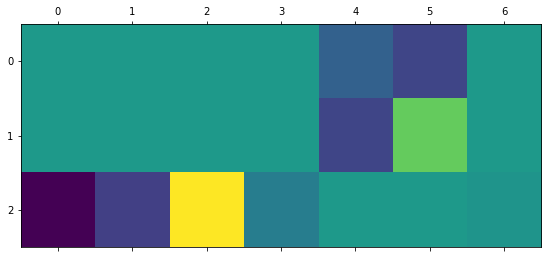

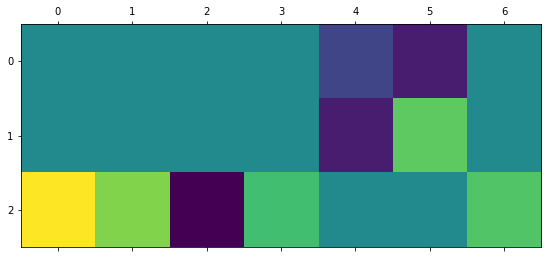

In [94]:
plt.matshow((amult(Uk.flatten()).reshape([nmo-nocc,nocc])))
plt.matshow(dV_mo[nocc:,:nocc])

In [95]:
np.allclose((Uk+amult(Uk.flatten()).reshape([nmo,nmo])),dV_mo,atol=2*1e-2)

ValueError: cannot reshape array of size 21 into shape (10,10)

In [74]:
dP_app=C@(Uk@O-O@Uk)@C.T    
print(np.linalg.norm(dP_app-dP))
print(np.linalg.norm(dP))
print(np.linalg.norm(dP_app))

0.6045428081344216
0.1788459732698106
0.5746263404725894


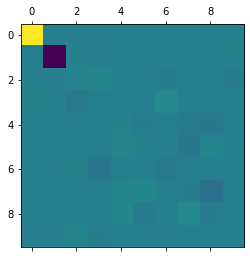

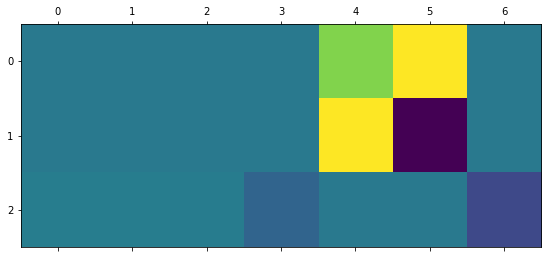

In [97]:
plt.matshow(U)
plt.matshow(Uk)

In [96]:
np.allclose(U,U.T)

False